# Transfer learning with BERT as a base model

In [31]:
# !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

















In [1]:
# load required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification # for sentimental analysis

## Load AG News Dataset

In [2]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')

In [3]:
ag_news_train_df.shape

(120000, 3)

In [4]:
ag_news_test_df.shape

(7600, 3)

In [5]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


<AxesSubplot:>

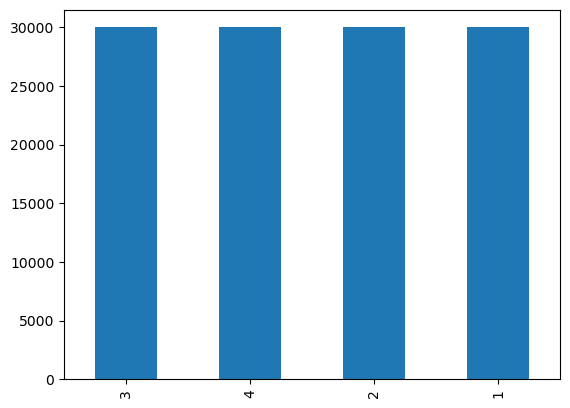

In [6]:
# equal distribution of classes
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

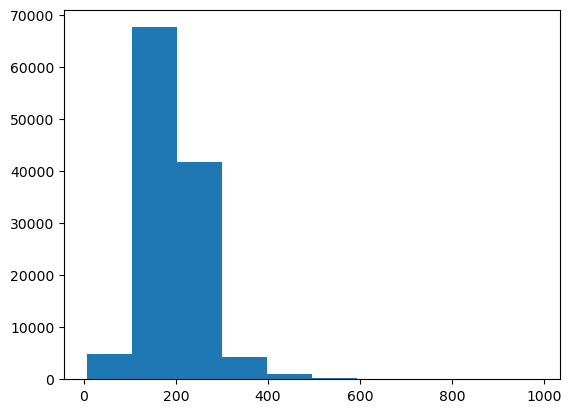

In [7]:
plt.hist(ag_news_train_df.Description.str.len())

## Data Preprocessing

In [8]:
# no instances with missing values
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

In [9]:
# merge two columns into one
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [10]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [11]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

# one hot encode target class
y_train_news = to_categorical(y_train_news)
y_test_news = to_categorical(y_test_news)

In [12]:
# split train-test 80-20 subsets
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size=0.2)

In [13]:
# for training is used only 1/8 of the training subset due to its size
np.random.seed(42)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

In [14]:
X_train_news_8th = X_train_news.take(news_train_idx)
y_train_news_8th = y_train_news[news_train_idx]

In [15]:
# load model tokenizer
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [16]:
# apply tokenizer or our dataset
train_encodings = tokenizer(list(X_train_news_8th),
                            truncation=True,
                            padding="max_length",
                            return_tensors="np",
                            return_token_type_ids=False)
valid_encodings = tokenizer(list(X_valid_news),
                            truncation=True,
                            padding="max_length",
                            return_tensors="np",
                            return_token_type_ids=False)
test_encodings = tokenizer(list(X_test_news),
                           truncation=True,
                           padding="max_length",
                           return_tensors="np",
                           return_token_type_ids=False)

In [17]:
# prepare tensor dataset that can be used for model training
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_news_8th
))

valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_encodings),
    y_valid_news
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_news
))

In [18]:
batch_size = 8

train_dataset = train_dataset.shuffle(2000).batch(batch_size, drop_remainder=True)
valid_dataset = valid_dataset.shuffle(2000).batch(batch_size, drop_remainder=True)
test_dataset = test_dataset.shuffle(2000).batch(batch_size, drop_remainder=True)

In [19]:
seq_num = train_dataset.take(1).element_spec[0]['input_ids'].shape[1]

## Model Development

In [20]:
# load pretrained model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# embedd input and output layers for model
input_ids = tf.keras.layers.Input(shape=(seq_num,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(seq_num,), name='attention_mask', dtype='int32')

embeddings = model.bert(input_ids, attention_mask)[1]

x = tf.keras.layers.Dense(seq_num * 2, activation='relu')(embeddings)
y = tf.keras.layers.Dense(len(y_train_news_8th[0]), activation='softmax', name='outputs')(x)

In [22]:
# build new model structure
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy')])

In [25]:
# train model
model.fit(train_dataset, validation_data=valid_dataset, epochs=3)

Epoch 1/3
1500/1500 [==============================] - 1366s 905ms/step - loss: 0.5195 - accuracy: 0.8188 - val_loss: 0.2935 - val_accuracy: 0.9046
Epoch 2/3
1500/1500 [==============================] - 1355s 903ms/step - loss: 0.2453 - accuracy: 0.9183 - val_loss: 0.2454 - val_accuracy: 0.9191
Epoch 3/3
1500/1500 [==============================] - 1354s 903ms/step - loss: 0.1820 - accuracy: 0.9389 - val_loss: 0.2398 - val_accuracy: 0.9205


### Evaluate on test subset

In [26]:
model.evaluate(test_dataset)

950/950 [==============================] - 169s 178ms/step - loss: 0.2506 - accuracy: 0.9170


[0.2505662441253662, 0.9169737100601196]

In [54]:
y_pred = model.predict(test_dataset)

950/950 [==============================] - 304s 315ms/step


### Save/Load News model
The model can be downloaded from https://drive.google.com/drive/folders/1MiA1fvj2YS6USLhtnXFTJDFWaTA7dNtN?usp=sharing

In [27]:
model.save("bert-news-model")

In [ ]:
saved_model = tf.keras.models.load_model('models/bert-news-model')

In [ ]:
saved_model.evaluate(test_dataset)